# Neural Networks
 
Today we will build a neural network (NN) from scratch. 

The structure of the NN is shown in the following image:
  
<img src="https://i1.wp.com/res.cloudinary.com/dxqnb8xjb/image/upload/v1539018324/nn_diagram_d7gs7e.png?w=456&ssl=1" />
 
 
This NN have three layers: 

- Input layer: this layer is constitute the input data
- Hidden layer: this is the most internal layer. This layer is not visible to the user that is why NN are considered black boxes. 
- Output layer: this layer will contain our output ($\hat{y}$)


<img src="https://cdnpythonmachinelearning.azureedge.net/wp-content/uploads/2017/09/Single-Perceptron.png?x31195" width="600" height="400" />
 
 
We proceed with the input layer and calculate the weights and the bias for each of the input (X's): transfer function
 
$$ z = W_{i1}^{T}X + b_1 $$

This is called the <b> Transfer Function </b>. After that, the resulting vector (z) is passed through an <b> Activation Function </b>. There are many types of activation functions, one of them we yet know, the <b>sigmoid function </b>:
 
$$   \sigma = 1 / (1 + exp^{-z})  $$

Lets code this functions:


## Activation function

In [1]:
#' the activation function
sigmoid <- function(x) {
  1.0 / (1.0 + exp(-x))
}


## Feedforward
 
The transfer and activation functions are applyed to the first layer (input layer) and the resuts are passed to the following layer (hidden layer) and both functions are now applied to it. Then the reult is passed to the output layer. Those passes are known as feedforward step. Now we will define this function:

In [2]:
### Feedforward from input to output
feedforward <- function(nn) {
  ## activation of the first layer
  nn$layer1 <- sigmoid(nn$input %*% nn$weights1)
  ## activation of the following layer
  nn$output <- sigmoid(nn$layer1 %*% nn$weights2)
  return(nn)
}


At the end, the final feedforward function for our network looks as follows:
 
$$ \hat{y} = \sigma(W_2^{T}(\sigma(W_1^{T}X) + b_1) + b_2 )  $$
 

## Backpropagation
 
The resulting output of the feedforward step gives a result that has a high error (loss). To reduce this error, the weight and bias are corrected by going backwards. This step is known as backpropagation. This is done by the following function:
 
$$  2(y - \hat{y}) * z(1-z) * X $$
 
where z is

$$  z = (W^{T}X + b) $$

and $ z(1-z) $ is known as the <b>derivative of the sigmoid function</b>.

Now we add the code for the backpropagation function:


In [3]:
#' the derivative of the activation function
sigmoid_derivative <- function(x) {
  return(x * (1.0 - x))
}

## Backpropagation
backprop <- function(nn) {
  # application of the chain rule to find derivative of the loss function with 
  # respect to weights2 and weights1
    
  # `2 * (nn$y - nn$output)` is the derivative of the sigmoid loss function
  d_weights2 <- ( t(nn$layer1) %*% (2 * (nn$y - nn$output) * sigmoid_derivative(nn$output)) )

  d_weights1 <- ( 2 * (nn$y - nn$output) * sigmoid_derivative(nn$output)) %*% t(nn$weights2)
    
  d_weights1 <- d_weights1 * sigmoid_derivative(nn$layer1)
    
  d_weights1 <- t(nn$input) %*% d_weights1
  
  # update the weights using the derivative (slope) of the loss function
  nn$weights1 <- nn$weights1 + d_weights1
  nn$weights2 <- nn$weights2 + d_weights2

  return(nn)
}


## Loss function
 
Now that we have all the needed functions for our NN, we have to define the loss function. We will use the Sum of Squared Error: 

$$  cost = \sum_{i=1}^{n} {(y - \hat{y})^{2}} $$


In [4]:
### Loss function: SSE
loss_function <- function(nn) {
  return(sum((nn$y - nn$output) ^ 2))
}


And  we define the gradient descent function by running the network (feed)fordward and backward (backpropagation) while recalculating the loss function:

In [5]:
GD <- function(nnet, num_iter=100) {
    n <- num_iter

    # data frame to store the results of the loss function.
    # this data frame is used to produce the plot in the 
    # next code chunk
    loss_df <- data.frame(iteration = 1:n+1, loss = vector("numeric", length = n) )

    for (i in seq_len(num_iter)) {
      nnet <- feedforward(nnet)
      nnet <- backprop(nnet)

      # store the result of the loss function.  We will plot this later
      loss_df$loss[i] <- loss_function(nnet)
    }
    # print the predicted outcome next to the actual outcome
    yhat <- data.frame("Predicted" = round(nnet$output, 3), "Actual" = y)
    res <- list(yhat=yhat, loss=loss_df)
    return(res)
}

In [6]:

NeuralNetwork <- function(X, y, num_nodes, num_iter=100) { #only 1 layer
    # generate a random value between 0 and 1 for each
    # element in X.  This will be used as our initial weights
    # for layer 1
    rand_vector <- runif(ncol(X) * nrow(X))

    # convert above vector into a matrix
    rand_matrix <- matrix(rand_vector, nrow = ncol(X), ncol = nrow(X), byrow = TRUE)

    # this list stores the state of our neural net as it is trained
    nnet <- list(input = X,                              # predictor variables
                  weights1 = rand_matrix,                 # weights for layer 1
                  weights2 = matrix(runif(num_nodes), ncol = 1),  # weights for layer 2
                  y = y,                                  # actual observed
                  output = matrix(rep(0, times = num_nodes), ncol = 1)   # stores the predicted outcome
                 )
    return(GD(nnet, num_iter))
}


In [11]:
#First, we create the data to train the neural network.
df <- read.csv(file = "C:/Users/Mayer/Documents/DataScience/data/mtcars.csv")
head(df)

,X,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,Mazda RX4,21.0,6,160,110,3.90,2.620,16.46,0,1,4,4
2,Mazda RX4 Wag,21.0,6,160,110,3.90,2.875,17.02,0,1,4,4
3,Datsun 710,22.8,4,108,93,3.85,2.320,18.61,1,1,4,1
4,Hornet 4 Drive,21.4,6,258,110,3.08,3.215,19.44,1,0,3,1
5,Hornet Sportabout,18.7,8,360,175,3.15,3.440,17.02,0,0,3,2
6,Valiant,18.1,6,225,105,2.76,3.460,20.22,1,0,3,1


In [24]:

# predictor variables
X <- as.matrix(df[,-10])
head(X)

X,mpg,cyl,disp,hp,drat,wt,qsec,vs,gear,carb
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,3,2
Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,3,1


In [23]:
# observed outcomes
y <- as.matrix(df[10])
head(y)

am
1
1
1
0
0
0


In [26]:
str(df)

'data.frame':	32 obs. of  12 variables:
 $ X   : Factor w/ 32 levels "AMC Javelin",..: 18 19 5 13 14 31 7 21 20 22 ...
 $ mpg : num  21 21 22.8 21.4 18.7 18.1 14.3 24.4 22.8 19.2 ...
 $ cyl : int  6 6 4 6 8 6 8 4 4 6 ...
 $ disp: num  160 160 108 258 360 ...
 $ hp  : int  110 110 93 110 175 105 245 62 95 123 ...
 $ drat: num  3.9 3.9 3.85 3.08 3.15 2.76 3.21 3.69 3.92 3.92 ...
 $ wt  : num  2.62 2.88 2.32 3.21 3.44 ...
 $ qsec: num  16.5 17 18.6 19.4 17 ...
 $ vs  : int  0 0 1 1 0 1 0 1 1 1 ...
 $ am  : int  1 1 1 0 0 0 0 0 0 0 ...
 $ gear: int  4 4 4 3 3 3 3 4 4 4 ...
 $ carb: int  4 4 1 1 2 1 4 2 2 4 ...


In [25]:
nn <- NeuralNetwork(X,y,num_nodes=4, num_iter=1000)


ERROR: Error in nn$input %*% nn$weights1: requires numeric/complex matrix/vector arguments


In [27]:
nn$yhat # the probability to get 1
head(nn$loss)
tail(nn$loss)

Predicted,Actual
<dbl>,<dbl>
0.025,0
0.979,1
0.966,1
0.031,0


,iteration,loss
,<dbl>,<dbl>
1,2,1.518857
2,3,1.247433
3,4,1.025016
4,5,1.000515
5,6,1.000378
6,7,1.000243


,iteration,loss
,<dbl>,<dbl>
995,996,0.003227988
996,997,0.003223035
997,998,0.003218096
998,999,0.003213171
999,1000,0.003208261
1000,1001,0.003203365


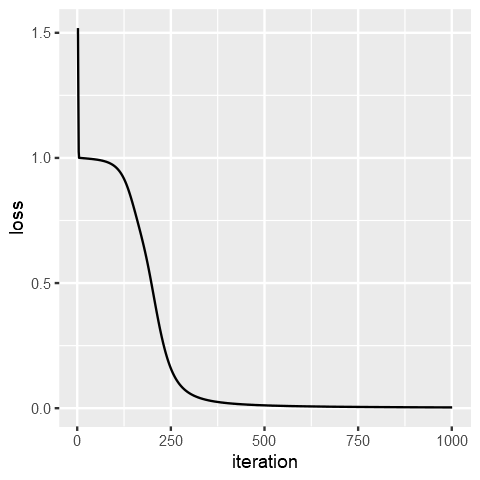

In [28]:
options(repr.plot.width = 4, repr.plot.height = 4)

# plot the cost
library(ggplot2)

ggplot(data = nn$loss, aes(x = iteration, y = loss)) +
  geom_line()
